# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import time
from PIL import Image

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.autograd import Variable
plt.rcParams['figure.figsize'] = 15,8

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/master/torchvision/transforms.html#)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. This converts the values of each color channel to be between -1 and 1 instead of 0 and 1.

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([ transforms.RandomRotation(30),
                                        transforms.RandomResizedCrop(224),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

vali_transforms = transforms.Compose([ transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


test_transforms = transforms.Compose([ transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=vali_transforms)
test_data = datasets.ImageFolder(test_dir, transform=vali_transforms)


trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)



In [4]:
## len(trainloader) returns number of batches that got created from dataset. len(trainoader.dataset) returns number
## of examples that are actually there. len(trainloader) == 103 == 6552/64
len(trainloader),len(trainloader.dataset),len(validloader),len(validloader.dataset),len(testloader),len(testloader.dataset)

(103, 6552, 26, 818, 26, 819)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [5]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [6]:
## We check whether GPU is available on PC or not otherwise we use CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [7]:
#vgg16 = models.vgg16_bn(pretrained=True).to(device)
resnet18 = models.resnet18(pretrained=True).to(device)
densenet121 = models.densenet121(pretrained=True).to(device)
vgg16 = models.vgg16(pretrained=True).to(device)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:01<00:00, 33551474.33it/s]
/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.torch/models/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:04<00:00, 6643088.31it/s] 
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:12<00:00, 42638087.73it/s]


In [8]:
'''models = {'resnet': resnet18, 'densenet':densenet121, 'vgg':vgg16}
print(models['densenet'])
'''

"models = {'resnet': resnet18, 'densenet':densenet121, 'vgg':vgg16}\nprint(models['densenet'])\n"

In [9]:
# TODO: Build and train your network
# Freeze parameters
for param in vgg16.parameters():
    param.requires_grad = False

classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(in_features=25088, out_features=4096)),
                          ('dropout1',nn.Dropout(0.15)),
                          ('relu1', nn.ReLU()),
                          ('fc2', nn.Linear(in_features=4096, out_features=512)),
                          ('dropout2', nn.Dropout(0.15)),
                          ('relu2', nn.ReLU()),
                          ('fc3', nn.Linear(in_features=512, out_features=102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
vgg16.classifier = classifier
vgg16.classifier = vgg16.classifier.to(device)
for param in vgg16.classifier.parameters():
    param.requires_grad = True

In [10]:
#for param in vgg16.parameters():
#    print(param.requires_grad)

In [11]:
# training network
start = time.time()
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.01, momentum=0.9)

## We are maintaining list of learning rate and epochs for that particular learning rate which we'll loop through.
## We take one learning rate and then do few epochs and then decrease learning rate and then do few epochs with 
## that learning rate. We keep on decreasing learning rate until we see that accuracy is improving little bit 
## by decreasing learning rate. we generally do not go further down tha 0.000001.
## if learning rate is too high and loss/accuracy is not changing then we decrease learning rate

epochs_list = [(0.01,8),(0.001,5),(0.0001,5),(0.00001,5),(0.000001,5)]
print_every =40
steps =0
## We call this method vgg16.train() which will activate BatchNormalization and Dropout layer which will be activated only during 
## training phase and needs to be frozen during evaluate/test phase.

vgg16.train()

for lr, epochs in epochs_list:
    optimizer.lr = lr
    for e in range(epochs):
        running_loss = 0
        correct = 0
        for images, labels in trainloader:
            steps += 1
            #input data
            images, labels = Variable(images), Variable(labels)   
            images, labels = images.to(device), labels.to(device) ## We call to(device) to transfer tensors between CPU and GPU
            #clear gradients calculated in previous step
            optimizer.zero_grad()       
            #forward +backward
            outputs = vgg16.forward(images)
            loss = criterion(outputs, labels)
            loss.backward()    
            #renew parameter updated according to new gradients and learning rate.
            optimizer.step()  
            _,preds = torch.max(outputs.data, 1)
            ## We caculate from this particular batch how many were caculated/guessed correctly by model.
            correct += (labels == preds).sum()

            #print out 
            running_loss += loss.item()
            
            ## We print loss at every 40 batches to check whether it's decresing or not. Ideally it should decrease.
            if steps % print_every == 0:
                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:4f}".format(running_loss/print_every))
                running_loss = 0
        print('Accuracy at %d epoch & Learning Rate : %f is %f %%' % (e+1, lr,float(correct) *100 / len(trainloader.dataset)))

    print('Finished Training in time : %f seconds' % (time.time() - start))

Epoch: 1/8..  Training Loss: 4.256706
Epoch: 1/8..  Training Loss: 2.848096
Accuracy at 1 epoch & Learning Rate : 0.010000 is 28.373016 %
Epoch: 2/8..  Training Loss: 0.747570
Epoch: 2/8..  Training Loss: 1.474975
Epoch: 2/8..  Training Loss: 1.398204
Accuracy at 2 epoch & Learning Rate : 0.010000 is 60.302198 %
Epoch: 3/8..  Training Loss: 0.996154
Epoch: 3/8..  Training Loss: 1.047581
Accuracy at 3 epoch & Learning Rate : 0.010000 is 69.612332 %
Epoch: 4/8..  Training Loss: 0.265401
Epoch: 4/8..  Training Loss: 0.910023
Epoch: 4/8..  Training Loss: 0.845642
Accuracy at 4 epoch & Learning Rate : 0.010000 is 74.893162 %
Epoch: 5/8..  Training Loss: 0.563429
Epoch: 5/8..  Training Loss: 0.771202
Accuracy at 5 epoch & Learning Rate : 0.010000 is 78.449328 %
Epoch: 6/8..  Training Loss: 0.086361
Epoch: 6/8..  Training Loss: 0.711175
Epoch: 6/8..  Training Loss: 0.725098
Accuracy at 6 epoch & Learning Rate : 0.010000 is 79.532967 %
Epoch: 7/8..  Training Loss: 0.327789
Epoch: 7/8..  Traini

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [12]:
# TODO: Do validation on the test set
## We are doing below evaluation on Validation Dataset generated above.
## We need to call vgg16.eval() method to put model in evaluation mode which will freeze BatchNormalization and Dropout layer 
## which does not need to be active during evaluation phase.They only need to be active during training time.
vgg16.eval()

## We need to use torch.no_grad() whenever we are evaluating mode as during this time we doe need to calculate gradients of
## various parameters which we generally do during training time as we need to update this parameters during training but
## not during test/evaluate time.

## Dropout randomly deactivates few neurons in particular layer so that model does not overfit training data
## like we had Linear Layer with 4096 neurons and Dropout of 0.5 will deactivate 50% of neurons which will 
## set only 2048 neurons active in that layer at valid and test time we are evaluating model so we don't worry
## about overfitting as we have model trained and parameters updated Dropout is used to avoid overfitting

with torch.no_grad():
    correct = 0
    total = 0
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    print('Accuracy of the network on the %d valid images: %d %%' % 
          (len(validloader.dataset), 100 * correct / total))


with torch.no_grad():
    correct = 0
    total = 0
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    print('Accuracy of the network on the %d test images: %d %%' % 
          (len(testloader.dataset), 100 * correct / total ))

Accuracy of the network on the 818 valid images: 93 %
Accuracy of the network on the 819 test images: 91 %


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [13]:
#%ls
#%rm checkpoint_88.pth
%ls

assets/            densenet_121.pth                predict.py
cat_to_name.json   flowers/                        README.md
checkpoint_88.pth  Image Classifier Project.ipynb  train.py
checkpoint_92.pth  LICENSE                         vgg_91.pth


In [14]:
#%rm checkpoint_82.pth

In [16]:
## Here we save all our weight and baises along with class_to_idx mapping so that we can load it later
## and use model with that trained parameters so that we don't have to waste time in training model every time.
## We get model ready to use by loading parameters.

vgg16.class_to_idx = train_data.class_to_idx

model_state_dict = vgg16.state_dict()
optimizer_state_dict = optimizer.state_dict()
loss_state_dict = criterion.state_dict()

checkpoint_dict = {
    'epochs': epochs,
    'model_dict': model_state_dict,
    'optimizer' : optimizer_state_dict,
    'loss' : loss_state_dict,
    'class_to_idx' : train_data.class_to_idx,
}
torch.save(checkpoint_dict, 'vgg_91.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [17]:
## when we load checkpoint, We generally create model empty with just architecture.
## that's why we have set (pretrained=False) because all weights and biases are saved in checkpoint
## we do not need to download from net.For classifier part we had declared our own classifier
## hence we have to set it otherwise checkpoint will fail while loading weights and biases
## because dimensions will not match because our classifier is different in dimension than default 
## that comes with vgg

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    reloaded_model = models.vgg16(pretrained=False).to(device)
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(in_features=25088, out_features=4096)),
                          ('dropout1',nn.Dropout(0.15)),
                          ('relu1', nn.ReLU()),
                          ('fc2', nn.Linear(in_features=4096, out_features=512)),
                          ('dropout2', nn.Dropout(0.15)),
                          ('relu2', nn.ReLU()),
                          ('fc3', nn.Linear(in_features=512, out_features=102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    reloaded_model.classifier = classifier
    reloaded_model.load_state_dict(checkpoint['model_dict'])
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(reloaded_model.classifier.parameters(), lr=0.01, momentum=0.9)
    optimizer.load_state_dict(checkpoint['optimizer'])
    criterion.load_state_dict(checkpoint['loss'])
    reloaded_model = reloaded_model.to(device)
    return reloaded_model,optimizer,criterion,checkpoint['class_to_idx']

model, optimizer, loss, class_to_idx = load_checkpoint('vgg_91.pth')
#print(model)

In [18]:
print(device)

cuda


In [19]:
## Testing Reloaded model with test dataset to check it's accuracy and check whether weights are loaded 
## proerly or not.
with torch.no_grad():
    correct = 0
    total = 0
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model.forward(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    print('Accuracy of the network on the %d test images: %d %%' % 
          (len(testloader.dataset), 100 * correct / total ))

Accuracy of the network on the 819 test images: 90 %


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [43]:
## Here we are preprocessing image before giving it to our model to predict its class.
## We have done same transformation above when we declared trainloader,validloader,testloader.
## We are here implementing it manually to see how it works internally in pytorch.

def process_image(image,normalize=True):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    img = Image.open(image)
    img = img.convert('RGB')
    img = np.array(img.resize((256,256)).crop((16,16,240,240))) ##Cropping image from center to get (224,224)
    to_tensor = transforms.ToTensor() ## Transoforming image to tensor so that image with pixel values 
    img = to_tensor(img)              ## between 0-255 gets transformed to 0-1 floats which our model expects.
    img = img.numpy()       ## Converting to numpy array fromm pytorch tensor for normalizatioin operation below.
    #print(img)
    img = img.transpose((1,2,0)) ## Converting image to (224,224,3) to do normalization with mean and std.
    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229,0.224,0.225])
    if normalize:
        img = ((img - mean) / std)
    img = img.transpose((2,0,1)) ## Converting image back to (3,224,224) which our model expects for precition.
    
    #print(img.shape)
    img = torch.tensor(img,dtype=torch.float32) ## Converting back to pytorch tensor.
    #print(img)
    
    #img = img.type(torch.float32)
    #print(img.size())
    return img

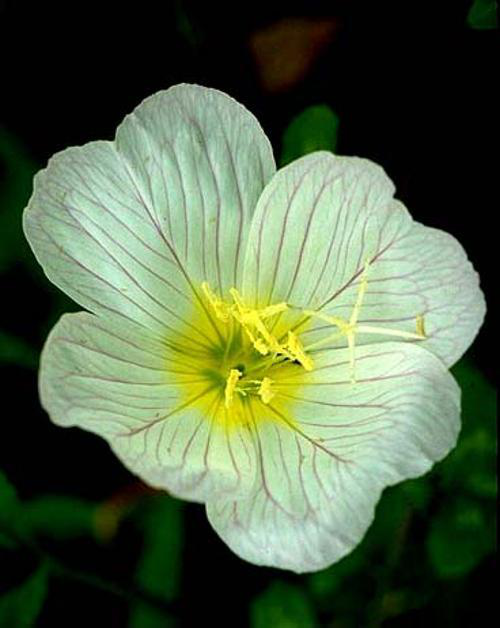

In [44]:
img = Image.open('flowers/valid/1/image_06739.jpg')
img

In [45]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    img = image.numpy()
    img = img.transpose((1, 2, 0))
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    img = np.clip(img, 0, 1)
    
    ax.imshow(img)
    
    return ax

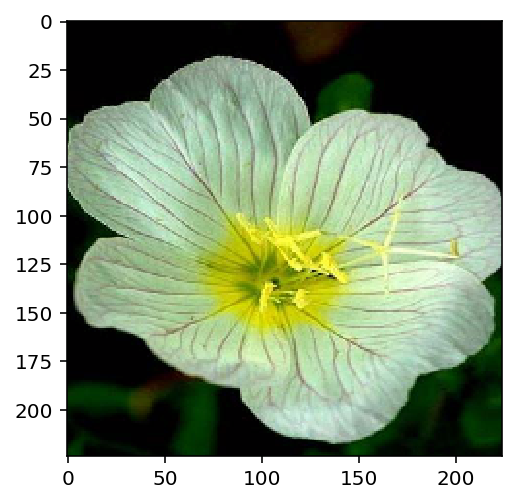

In [46]:
#%ls flowers/valid/1/image_06739.jpg
imshow(process_image('flowers/valid/1/image_06739.jpg'))
#imshow(process_image('flowers/valid/1/image_06739.jpg',normalize=False))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [24]:
#vgg16.cuda()

In [47]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # TODO: Implement the code to predict the class from an image file
    with torch.no_grad():
        #img = Image.open(image_path)
        #img = test_transforms(img)
        img = process_image(image_path)
        #print(len(img.size()))
        ## Our model expects first dimension as batch_size hence using unsqueeze method 
        ## to translate (3,224,224) to (1,3,224,224)
        output = model.forward(img.unsqueeze(0).to(device) if len(img.size())==3 else img.to(device))
        top_5_probs,classes = output.topk(topk)
        return top_5_probs, classes


In [48]:
predict('flowers/valid/1/image_06739.jpg',model.cuda())
#img = process_image('flowers/valid/1/image_06739.jpg')
#img.transpose(1,2).size()

(tensor([[-0.0121, -5.0600, -5.7639, -6.5939, -7.4426]], device='cuda:0'),
 tensor([[  0,  13,  50,  90,  87]], device='cuda:0'))

In [27]:
#for image,label in trainloader:
#    print(image[0])
#    break

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

<Container object of 5 artists>

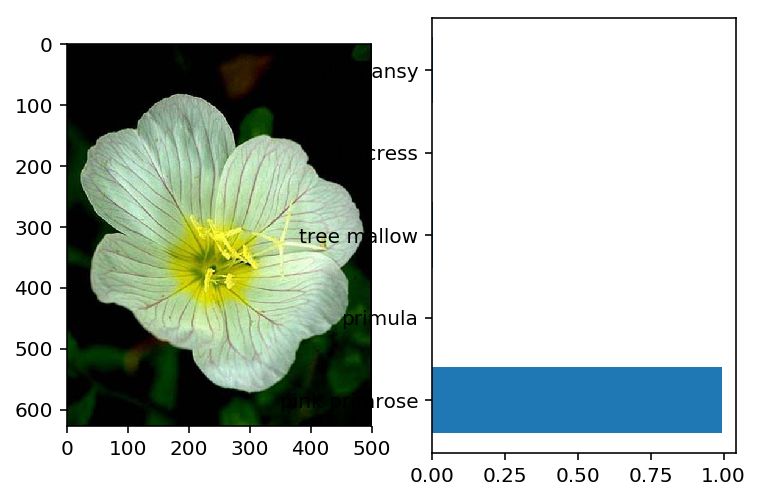

In [42]:
flower = 'flowers/valid/1/image_06739.jpg'

## We are using subplot to show 2 images next to each other. Here (1,2) is 1 row and 2 columns. 
## Third 1 puts image in first position.
plt.subplot(121)

## We get inverse dictionary as we get indexes from our model and we convert it to key of cat_to_json dictionary.
class_to_idx2 = dict(zip(class_to_idx.values(),class_to_idx.keys()))
plt.imshow(Image.open(flower))
probs2, idx2 = predict(flower,model)

## From indexes we get key of cat_to_name and then cat_to_name gives us flower name..
names = [cat_to_name[class_to_idx2[i.item()]] for i in idx2.data[0]]
probs = probs2.data[0].cpu().numpy()
probs = np.exp(probs)

## Third value 2 puts image in 2nd place
plt.subplot(122)
## barh puts bar chart in horizontal position. only bar method puts chart vertically.

plt.barh(names,probs)

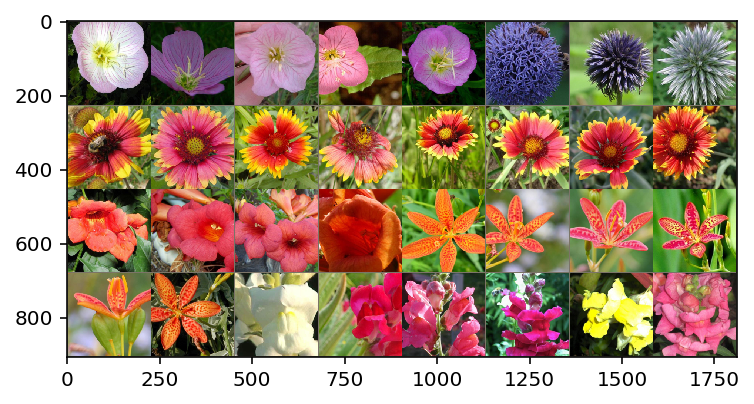

In [35]:
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))